In [40]:
import pandas as pd

url = 'https://github.com/ZhuofeiL/Wild-fire/blob/main/us_fire_2014_with_weather.csv?raw=true'
df = pd.read_csv(url)
print(df.head())


                         NWCG_REPORTING_UNIT_NAME  DISCOVERY_TIME  \
0                           Carlsbad Field Office            1820   
1                      Southern California Agency            1743   
2                      Southern California Agency            1720   
3  Arizona State Forestry Division - State Office            1859   
4                           Tonto National Forest            1815   

    STAT_CAUSE_DESCR STATE  temperature(C)       date  east_wind  north_wind  \
0          Lightning    NM       33.122093  6/19/2014  -0.262423    3.470904   
1      Equipment Use    CA       16.334345  6/19/2014  -1.036775    2.397915   
2      Equipment Use    CA       16.334345  6/19/2014  -1.036775    2.397915   
3  Missing/Undefined    AZ       33.615350  6/19/2014   7.367736    1.518968   
4      Miscellaneous    AZ       24.779810  6/19/2014   7.911876    2.566023   

         rh  
0  0.199127  
1  0.439357  
2  0.439357  
3  0.093330  
4  0.156054  


Size of the dataset:  (53118, 9)


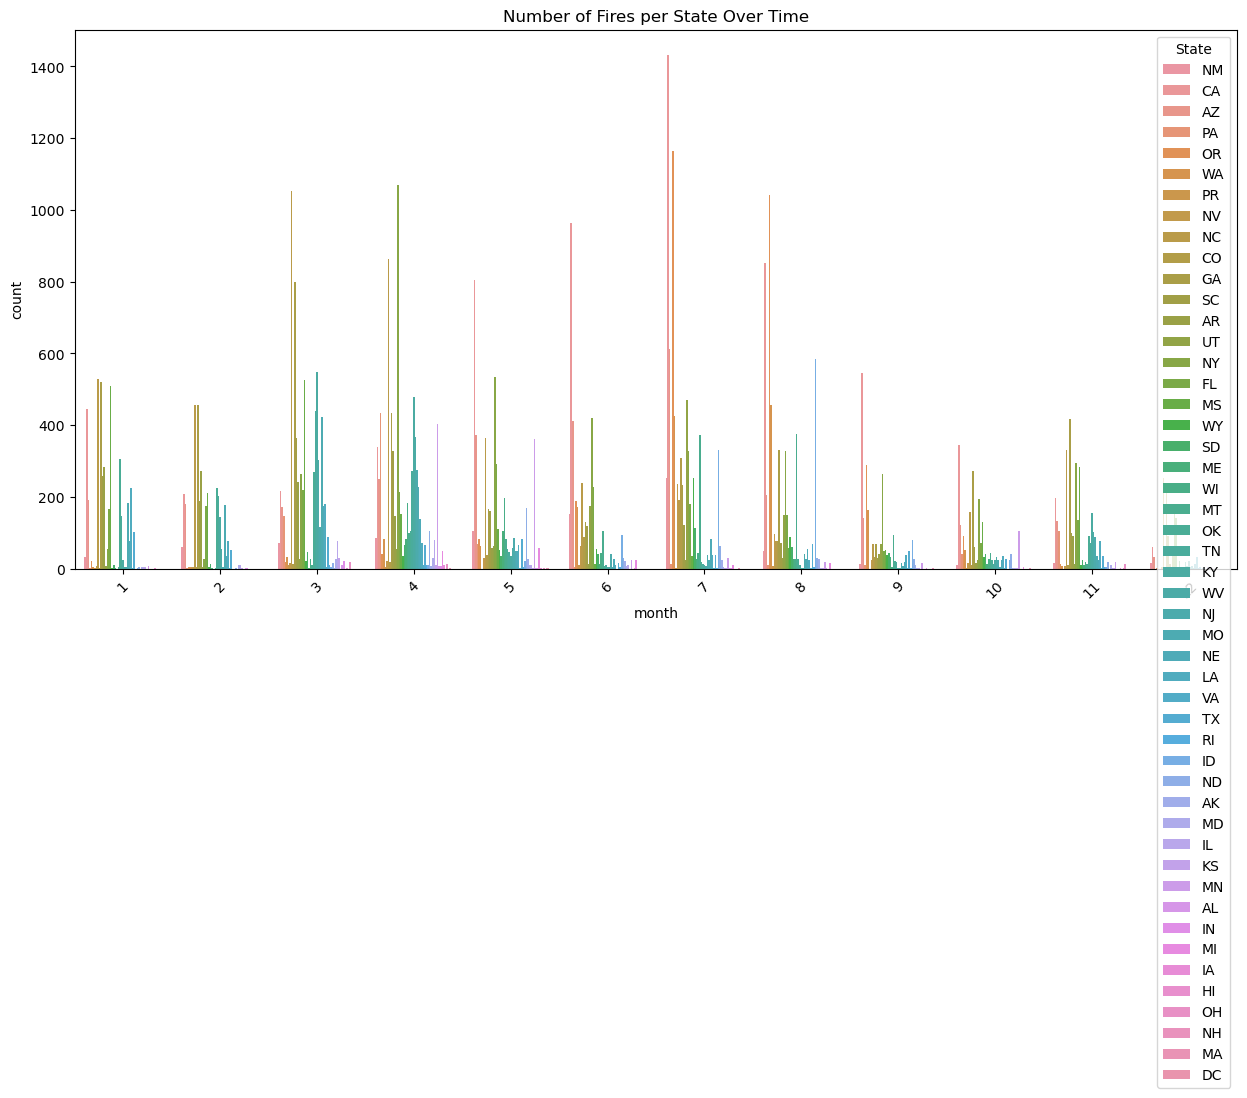

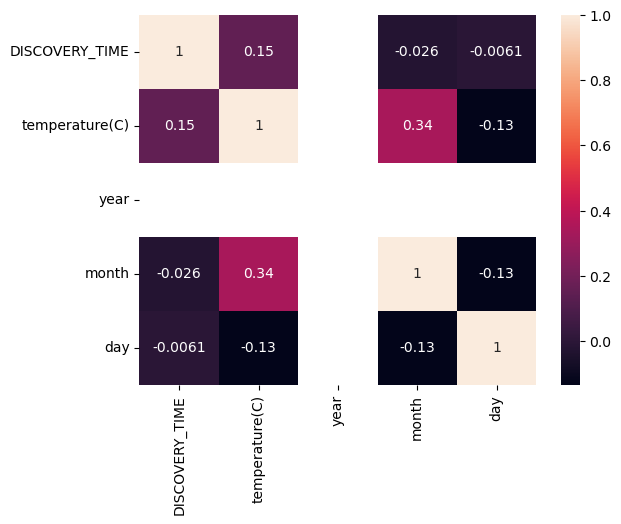

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://github.com/ZhuofeiL/Wild-fire/blob/main/us_fire_2014_with_weather.csv?raw=true') 

df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

print("Size of the dataset: ", df.shape)

plt.figure(figsize=(15, 7))
sns.countplot(x='month', hue='STATE', data=df)
plt.title('Number of Fires per State Over Time')
plt.legend(loc='upper right', title='State')
plt.xticks(rotation=45)
plt.show()

numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df = pd.read_csv('https://github.com/ZhuofeiL/Wild-fire/blob/main/us_fire_2014_with_weather.csv?raw=true')  # Replace 'your_dataset.csv' with the path to your dataset

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

grouped = df.groupby(['STATE', 'month'])
fires_per_month_state = grouped.size().reset_index(name='fire_count')
fires_per_month_state['avg_temperature'] = grouped['temperature(C)'].mean().values
fires_per_month_state['avg_east_wind'] = grouped['east_wind'].mean().values
fires_per_month_state['avg_north_wind'] = grouped['north_wind'].mean().values
fires_per_month_state['avg_humidity'] = grouped['Humidity'].mean().values

X = fires_per_month_state[['STATE', 'month', 'avg_temperature', 'avg_east_wind', 'avg_north_wind', 'avg_humidity']]
y = fires_per_month_state['fire_count']

ct = ColumnTransformer(
    [('state_encoder', OneHotEncoder(handle_unknown='ignore'), ['STATE']),
     ('numerical_scaler', StandardScaler(), ['month', 'avg_temperature', 'avg_east_wind', 'avg_north_wind', 'avg_humidity'])],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline(
    [('preprocessor', ct),
     ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

def predict_fire_count(state, month, avg_temperature, avg_east_wind, avg_north_wind, avg_humidity):
    input_features = pd.DataFrame([[state, month, avg_temperature, avg_east_wind, avg_north_wind, avg_humidity]], 
                                  columns=['STATE', 'month', 'avg_temperature', 'avg_east_wind', 'avg_north_wind', 'avg_humidity'])
    fire_count_prediction = pipeline.predict(input_features)[0]
    return fire_count_prediction


Mean Squared Error: 23071.784964646467
R^2 Score: 0.3548217031447358


In [52]:
predicted_fire_count = predict_fire_count('TX', 7, 33.0, 5.0, 3.0, 0.2)
print("Predicted Fire Count:", predicted_fire_count)

Predicted Fire Count: 131.89
